<a href="https://colab.research.google.com/github/S1ahruday/data-analysis-python/blob/main/DAP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loaded columns: ['Ranking', 'Country', 'Region', 'HappinessScore', 'GDP_per_capita', 'Social_support', 'Healthy_life_expectancy', 'Freedom', 'Generosity', 'Corruption', 'Year']
Shape: (1502, 11)
After dropping bad rows, shape: (1502, 11)

Happiness sample (first 6): [7.587, 7.561, 7.527, 7.522, 7.427, 7.406]
Sample countries: ['Switzerland', 'Iceland', 'Denmark', 'Norway', 'Canada', 'Finland', 'Netherlands', 'Sweden', 'New Zealand', 'Australia']
Matrix example columns: ['GDP_per_capita', 'Social_support', 'Healthy_life_expectancy']
Matrix example shape: (6, 3)


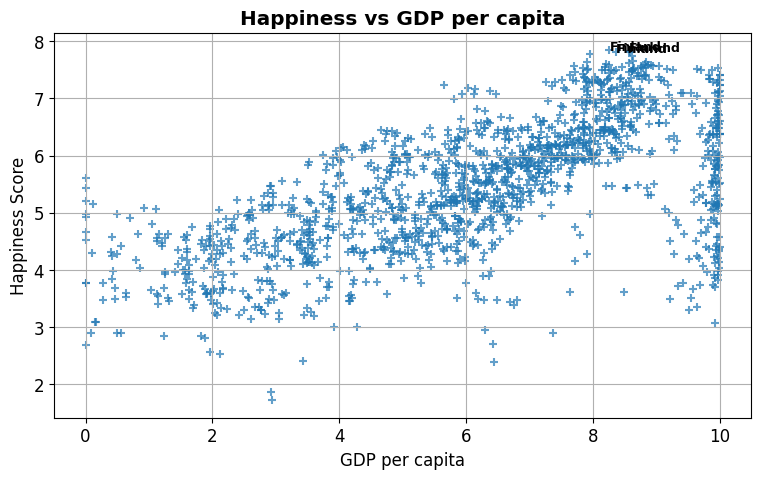

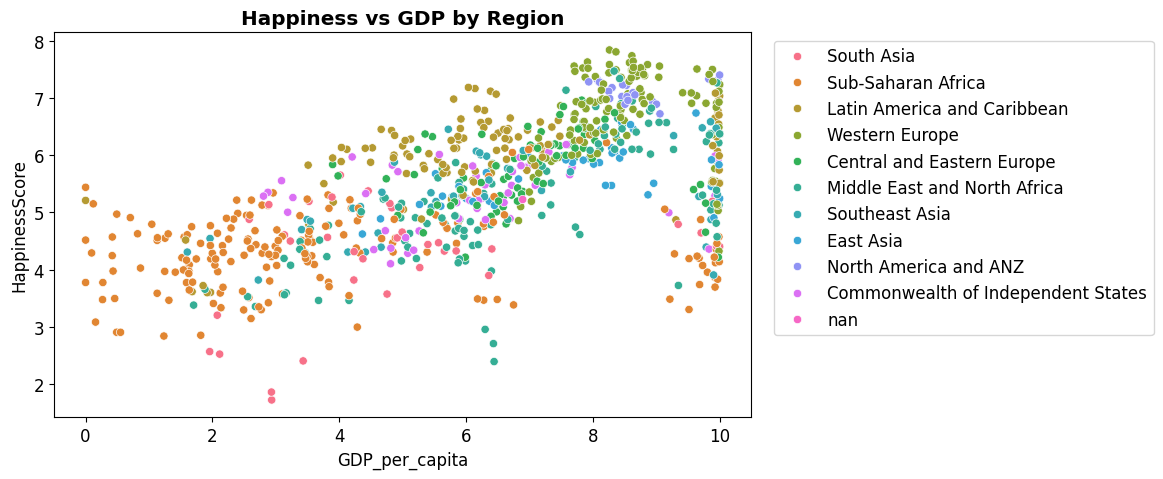

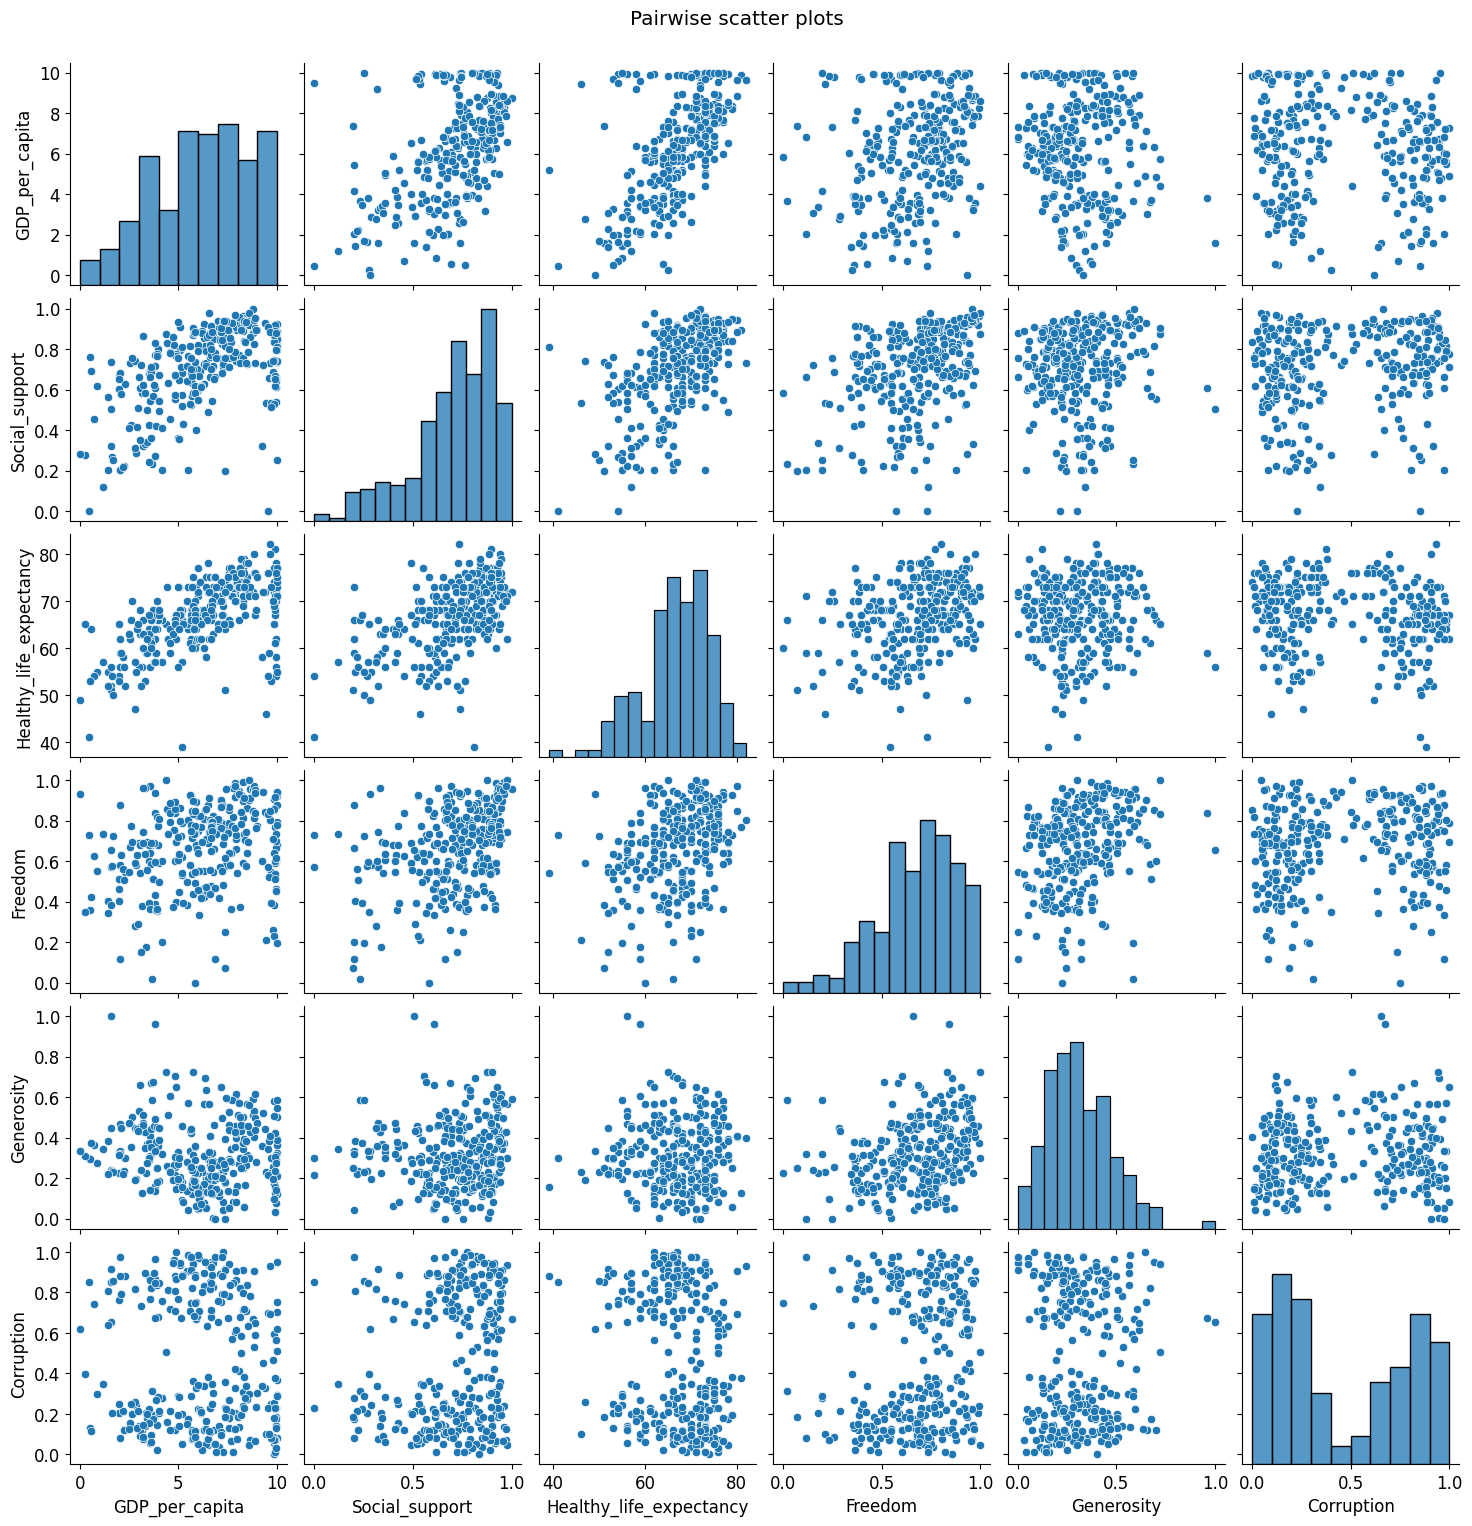

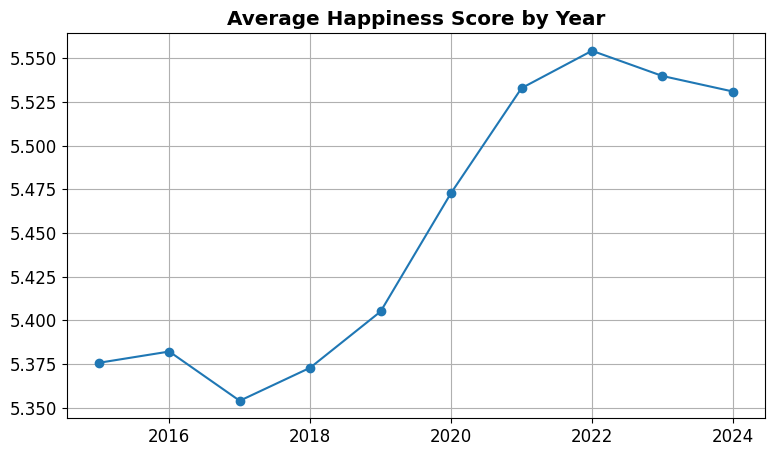

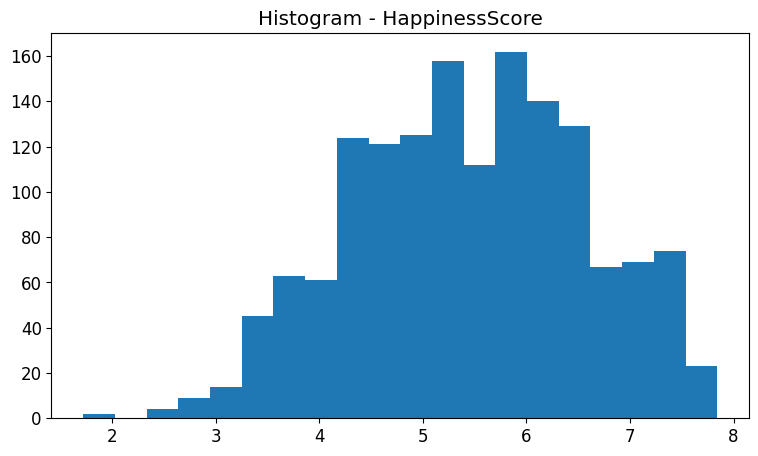

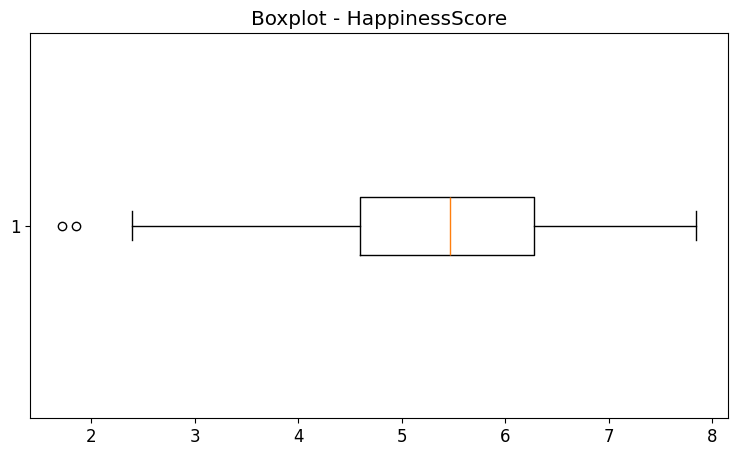


Descriptive statistics (HappinessScore):
count    1502.000000
mean        5.448857
std         1.125638
min         1.721000
25%         4.593425
50%         5.469650
75%         6.278450
max         7.842100
Name: HappinessScore, dtype: float64


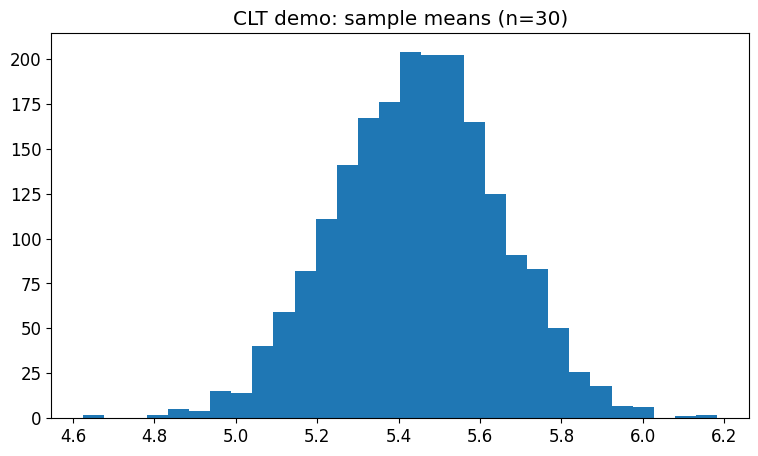

CLT sample means mean/std: 5.446326956666667 0.20388862136616082

pnorm(1.96): 0.9750021048517795 qnorm(0.975): 1.959963984540054 dnorm(0): 0.3989422804014327


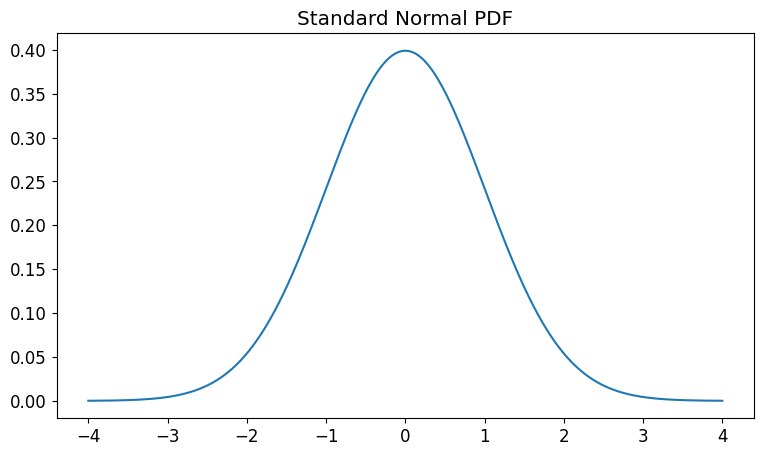

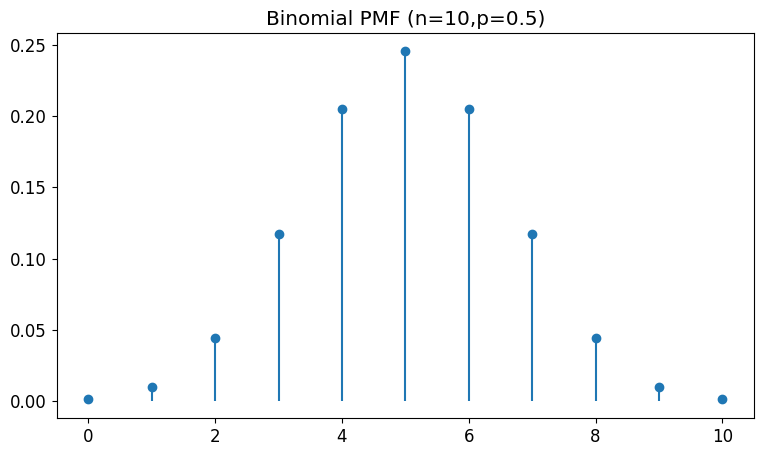

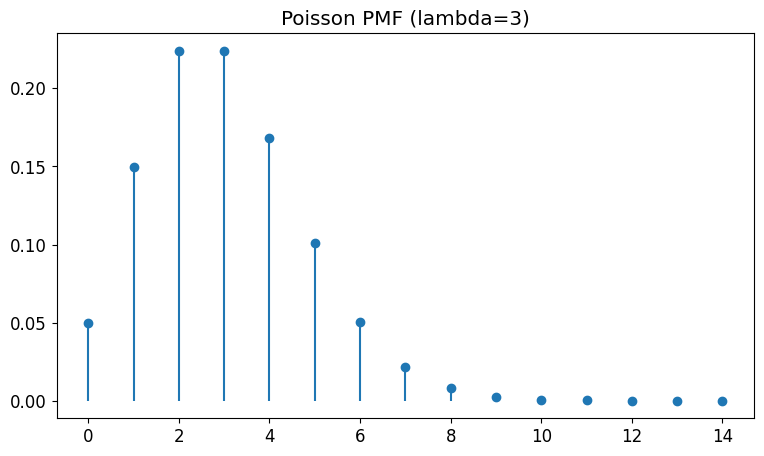


One-sample t-test vs 5.5: t= -1.7608439379257887 p= 0.07846842873398718
One-sample variance chi2= 1901.857867417344 p(two-sided)= 1.3554268818438686e-11

Two-sample z-test (approx): z= -3.622491692330927 p= 0.00029177883470116726
Two-sample t-test (equal var): t= -3.6224916923309274 p= 0.0003484926567792085
Welch t-test: t= -7.666035592415712 p= 3.826359575081084e-13


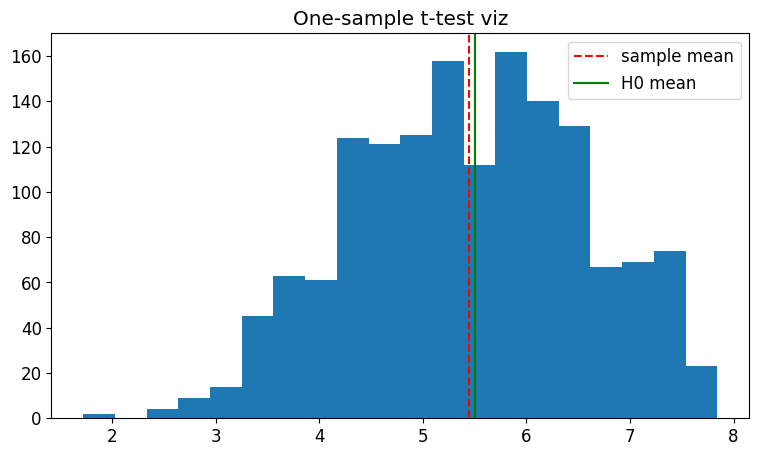


Paired t-test comparing 2023 vs 2024: t=-1.9775343501513278, p=0.05006446871268006

F-test (variance ratio): 18.66053281880234 p(two-sided approx): 2.220446049250313e-16

ANOVA dataset shape: (1502, 2) Unique regions: 11

ANOVA table:
                 sum_sq      df           F         PR(>F)
C(Region)  1129.086096     9.0  242.128203  4.888915e-284
Residual    771.496339  1489.0         NaN            NaN

Tukey HSD summary:
                            Multiple Comparison of Means - Tukey HSD, FWER=0.05                             
              group1                             group2               meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------------------------------
        Central and Eastern Europe Commonwealth of Independent States  -0.3776 0.0027 -0.6784 -0.0768   True
        Central and Eastern Europe                          East Asia   -0.052    1.0 -0.3947  0.2906  False
        Central and East

In [4]:
# world_happiness_final_updated.py
# Ready-to-run, updated, and robust code for your cleaned dataset
# Works with: world_happiness_cleaned_parsed.csv
# Implements UNIT I - V and includes safe ANOVA/Tukey/contingency handling
#
# Requirements:
# pip install pandas numpy matplotlib seaborn scipy statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats import weightstats as smw

plt.rcParams.update({'figure.figsize': (9,5), 'font.size': 12})

# -------------------------
# 0. Load cleaned dataset
# -------------------------
DF_PATH = "/content/world_happiness.csv" # Changed from world_happiness.csv to Dataset.csv, but Dataset.csv was not found.
df = pd.read_csv(DF_PATH)

# Basic checks & casts
expected_cols = ['Ranking','Country','Region','HappinessScore','GDP_per_capita',
                 'Social_support','Healthy_life_expectancy','Freedom','Generosity',
                 'Corruption','Year']
print("Loaded columns:", df.columns.tolist())
print("Shape:", df.shape)

# Ensure numeric columns are numeric (coerce bad values to NaN)
numeric_cols = ['Ranking','HappinessScore','GDP_per_capita','Social_support',
                'Healthy_life_expectancy','Freedom','Generosity','Corruption','Year']
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Normalize Region and Country strings
if 'Region' in df.columns:
    df['Region'] = df['Region'].astype(str).str.strip()
    df.loc[df['Region']=='', 'Region'] = np.nan
if 'Country' in df.columns:
    df['Country'] = df['Country'].astype(str).str.strip()

# Drop rows lacking the key fields we will use
df = df.dropna(subset=['HappinessScore', 'Country']).reset_index(drop=True)
print("After dropping bad rows, shape:", df.shape)

# -------------------------
# UNIT I: Data structures & EDA
# -------------------------

# Vector / Series example
h_vec = df['HappinessScore']
print("\nHappiness sample (first 6):", h_vec.head(6).tolist())

# List example
print("Sample countries:", list(df['Country'].unique())[:10])

# Matrix example (numpy)
matrix_cols = [c for c in ['GDP_per_capita','Social_support','Healthy_life_expectancy'] if c in df.columns]
if matrix_cols:
    print("Matrix example columns:", matrix_cols)
    matrix_example = df[matrix_cols].dropna().to_numpy()[:6,:]
    print("Matrix example shape:", matrix_example.shape)

# Scatter plot (marker '+'), annotate top 3
if 'GDP_per_capita' in df.columns:
    plt.figure()
    plt.scatter(df['GDP_per_capita'], df['HappinessScore'], marker='+', alpha=0.7)
    plt.title("Happiness vs GDP per capita", fontweight='bold')
    plt.xlabel("GDP per capita")
    plt.ylabel("Happiness Score")
    top3 = df.nlargest(3, 'HappinessScore')
    for _, r in top3.iterrows():
        plt.text(r['GDP_per_capita'], r['HappinessScore'], r['Country'], fontsize=9, fontweight='bold')
    plt.grid(True)
    plt.show()

# Colorful scatter by Region (safe sampling to avoid plotting too many points)
if 'Region' in df.columns and 'GDP_per_capita' in df.columns:
    sample_df = df.sample(min(800, len(df)))
    plt.figure()
    sns.scatterplot(data=sample_df, x='GDP_per_capita', y='HappinessScore', hue='Region', legend='full')
    plt.title("Happiness vs GDP by Region", fontweight='bold')
    plt.legend(bbox_to_anchor=(1.02,1), loc='upper left')
    plt.show()

# Pairplot (pairwise scatter diagrams) - sample to limit plot size
pair_cols = [c for c in ['GDP_per_capita','Social_support','Healthy_life_expectancy','Freedom','Generosity','Corruption'] if c in df.columns]
if len(pair_cols) >= 3:
    sns.pairplot(df[pair_cols].dropna().sample(min(300, len(df))), diag_kind='hist')
    plt.suptitle("Pairwise scatter plots", y=1.02)
    plt.show()

# Time series plot: average HappinessScore by year
if 'Year' in df.columns:
    ts = df.groupby('Year')['HappinessScore'].mean().reset_index()
    plt.figure()
    plt.plot(ts['Year'], ts['HappinessScore'], marker='o')
    plt.title("Average Happiness Score by Year", fontweight='bold')
    plt.grid(True)
    plt.show()

# Histogram and boxplot
plt.figure(); plt.hist(df['HappinessScore'].dropna(), bins=20); plt.title("Histogram - HappinessScore"); plt.show()
plt.figure(); plt.boxplot(df['HappinessScore'].dropna(), vert=False); plt.title("Boxplot - HappinessScore"); plt.show()

# Descriptive statistics
print("\nDescriptive statistics (HappinessScore):")
print(df['HappinessScore'].describe())

# -------------------------
# UNIT II: Probability & CLT
# -------------------------
pop = df['HappinessScore'].dropna().values

def clt_demo(pop, sample_size=30, reps=2000):
    return np.array([np.mean(np.random.choice(pop, sample_size, replace=True)) for _ in range(reps)])

if len(pop) > 0:
    sample_means = clt_demo(pop, sample_size=30, reps=2000)
    plt.figure(); plt.hist(sample_means, bins=30); plt.title("CLT demo: sample means (n=30)"); plt.show()
    print("CLT sample means mean/std:", sample_means.mean(), sample_means.std())

# Normal distribution functions (rnorm/ pnorm / qnorm / dnorm analogues)
from scipy.stats import norm
print("\npnorm(1.96):", norm.cdf(1.96), "qnorm(0.975):", norm.ppf(0.975), "dnorm(0):", norm.pdf(0))
x = np.linspace(-4,4,300); plt.figure(); plt.plot(x, norm.pdf(x)); plt.title("Standard Normal PDF"); plt.show()

# -------------------------
# UNIT III: Binomial & Poisson
# -------------------------
from scipy.stats import binom, poisson
# Binomial PMF example
x = np.arange(0,11)
plt.figure(); plt.stem(x, binom.pmf(x, 10, 0.5), basefmt=" "); plt.title("Binomial PMF (n=10,p=0.5)"); plt.show()
# Poisson PMF example
x = np.arange(0,15)
plt.figure(); plt.stem(x, poisson.pmf(x, 3), basefmt=" "); plt.title("Poisson PMF (lambda=3)"); plt.show()

# -------------------------
# UNIT IV: Inferential Statistics & Hypothesis Testing
# -------------------------

# One-sample t-test: H0 mean = 5.5 (example)
sample = df['HappinessScore'].dropna()
tstat, pval = stats.ttest_1samp(sample, 5.5)
print("\nOne-sample t-test vs 5.5: t=", tstat, "p=", pval)

# One-sample variance test (chi-square) example (H0 variance = 1)
n = sample.size
s2 = sample.var(ddof=1)
chi2_stat = (n - 1) * s2 / 1.0
p_lower = stats.chi2.cdf(chi2_stat, df=n-1)
p_two = 2 * min(p_lower, 1 - p_lower)
print("One-sample variance chi2=", chi2_stat, "p(two-sided)=", p_two)

# Two-sample comparisons: pick first two regions with enough data
regions = df['Region'].dropna().unique()
if len(regions) >= 2:
    r1, r2 = regions[0], regions[1]
    g1 = df[df['Region'] == r1]['HappinessScore'].dropna()
    g2 = df[df['Region'] == r2]['HappinessScore'].dropna()
    # Z-test (approx) - try safely
    try:
        zstat, pz = smw.ztest(g1, g2)
        print("\nTwo-sample z-test (approx): z=", zstat, "p=", pz)
    except Exception as e:
        print("\nTwo-sample z-test not available:", str(e))
    # Two-sample t-tests
    t_eq, p_eq = stats.ttest_ind(g1, g2, equal_var=True)
    t_w, p_w = stats.ttest_ind(g1, g2, equal_var=False)
    print("Two-sample t-test (equal var): t=", t_eq, "p=", p_eq)
    print("Welch t-test: t=", t_w, "p=", p_w)

# Visualize one-sample t test
plt.figure(); plt.hist(sample, bins=20); plt.axvline(sample.mean(), color='red', linestyle='--', label='sample mean'); plt.axvline(5.5, color='green', label='H0 mean'); plt.legend(); plt.title("One-sample t-test viz"); plt.show()

# -------------------------
# UNIT V: Paired t-test, F-test, ANOVA, Contingency
# -------------------------

# Paired t-test: compare last two years if available
if 'Year' in df.columns:
    yrs = sorted(df['Year'].dropna().unique())
    if len(yrs) >= 2:
        y1, y2 = yrs[-2], yrs[-1]
        pivot = df[df['Year'].isin([y1, y2])].pivot(index='Country', columns='Year', values='HappinessScore').dropna()
        if pivot.shape[0] >= 5:
            t_p, p_p = stats.ttest_rel(pivot[y1], pivot[y2])
            print(f"\nPaired t-test comparing {y1} vs {y2}: t={t_p}, p={p_p}")

# F-test for equal variances between two example groups (r1 vs r2)
def f_test(a, b):
    s1 = a.var(ddof=1); s2 = b.var(ddof=1)
    if s2 == 0:
        return np.nan, np.nan
    F = s1 / s2
    dfn = a.size - 1; dfd = b.size - 1
    p_one = 1 - stats.f.cdf(F, dfn, dfd)
    p_two = 2 * min(p_one, 1 - p_one)
    return F, p_two

if len(regions) >= 2:
    Fstat, Fp = f_test(g1, g2)
    print("\nF-test (variance ratio):", Fstat, "p(two-sided approx):", Fp)

# SAFE ANOVA + Tukey + Contingency (handles mixed types and small groups)
# Normalize Region column and drop invalid rows
df['Region'] = df['Region'].astype(str).str.strip()
df.loc[df['Region'] == '', 'Region'] = np.nan
df_anova = df[['Region', 'HappinessScore']].dropna().copy()
df_anova['HappinessScore'] = pd.to_numeric(df_anova['HappinessScore'], errors='coerce')
df_anova = df_anova.dropna()

print("\nANOVA dataset shape:", df_anova.shape, "Unique regions:", df_anova['Region'].nunique())

if df_anova['Region'].nunique() >= 2:
    model = smf.ols('HappinessScore ~ C(Region)', data=df_anova).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("\nANOVA table:\n", anova_table)

    # Tukey HSD post-hoc safely
    try:
        tukey_res = pairwise_tukeyhsd(endog=df_anova['HappinessScore'].values,
                                      groups=df_anova['Region'].values,
                                      alpha=0.05)
        print("\nTukey HSD summary:")
        print(tukey_res.summary())
    except Exception as e:
        print("Tukey HSD failed:", str(e))
else:
    print("Not enough region groups for ANOVA/Tukey (need >=2).")

# Contingency table with category bins & chi-square (drop degenerate rows/cols)
df_ct = df[['Region', 'HappinessScore']].dropna().copy()
df_ct['Category'] = pd.cut(df_ct['HappinessScore'], bins=[-np.inf,4,6,8,np.inf], labels=['Low','Medium','High','Very High'])
ct = pd.crosstab(df_ct['Region'], df_ct['Category'])
ct = ct.loc[(ct.sum(axis=1) > 0), (ct.sum(axis=0) > 0)]
print("\nContingency table shape:", ct.shape)
print(ct.head())

if ct.size == 0 or ct.shape[0] < 2 or ct.shape[1] < 2:
    print("Contingency table too small for chi-square test.")
else:
    chi2, pchi, dof, expected = stats.chi2_contingency(ct)
    print("\nChi-square test on contingency: chi2=%.4f, p=%.4g, dof=%d" % (chi2, pchi, dof))

# -------------------------
# Save cleaned subset (optional)
# -------------------------
out_clean = "world_happiness_final_for_analysis.csv"
df.to_csv(out_clean, index=False)
print("\nSaved cleaned dataframe for analysis to:", out_clean)
